# Regularized least squared problem with kernels with position and velocity as input

### import libraries

In [35]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from numpy.random import randn

### General system for damped oscilator

$
\ddot{x}(t) + 2\zeta\omega_0 \dot{x}(t) + \omega_0^2 x(t) = 0
$

#### Description of variables:
- $ x(t) $: position 
- $ \dot{x}(t) $: Velocity 
- $ \ddot{x}(t) $: acceleration
- $ \zeta $: The damping factor, which determines how quickly the oscillations decay (due to friction or resistance).
- $ \omega_0 $: The natural frequency of the system (eigenfrequency)
- $ t $: Time unit.

In [36]:
zeta = 0*0.2/np.sqrt(2)
omega_0 = 0.2* 2* np.pi
def damped_oscillator(t, x):  #remember that independent value t comes first
    x_dot = - 2* zeta * omega_0 * x[1] - omega_0**2 * x[0] # x'' = -2*z*w0*x' - w0^2 * x rewritten as a system of first order 
    return [x[1], x_dot]  #y[1] = velocity and y_dot = acceleration. return both since system is rewritten as 2 first order diffs.

### solving the differential equation numerically with scipy

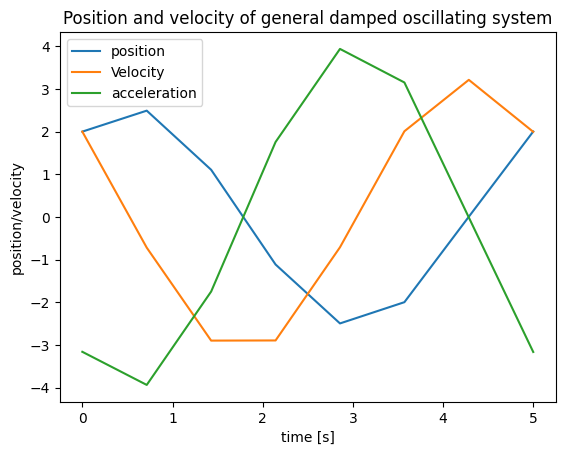

In [37]:
init_values = [2, 2]  # Initial condition [position, velocity]
num_datapoints = 8
timespan = [0, 5]
t = np.linspace(0, 5, num_datapoints)
sol = solve_ivp(damped_oscillator, (t[0], t[-1]), init_values, t_eval = t)#time interval first, then initial values for position and velocity
p  = sol.y[0]
v = sol.y[1]
a = - 2* zeta * omega_0 * v - omega_0**2 * p  #calculating accelerations from positions and velocities

plt.plot(t, p, label = "position")
plt.plot(t, v, label = "Velocity")
plt.plot(t, a, label = "acceleration")
plt.xlabel("time [s]")
plt.ylabel("position/velocity")
plt.title("Position and velocity of general damped oscillating system")
plt.legend()
plt.show()

### Phase plot of the oscilator

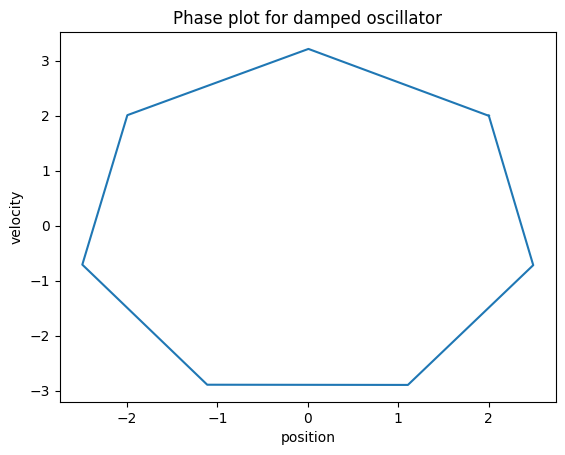

In [38]:
plt.plot(p, v)
plt.xlabel("position")
plt.ylabel("velocity")
plt.title("Phase plot for damped oscillator")
plt.show()

### Discretizing the dataset for with gaussian noise

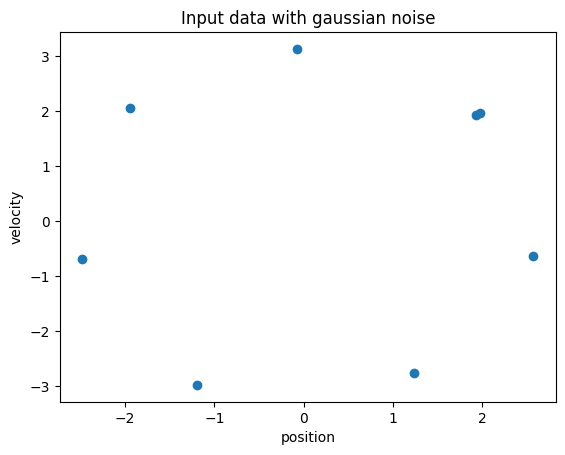

In [39]:
def generate_noisy_data(p, v, a, noise_std=0.1):
    gaussian_noise = np.random.normal(0, noise_std, len(p))
    # Add noise to position, velocity, and acceleration
    p_noisy = p + gaussian_noise
    v_noisy = v + gaussian_noise
    a_noisy = a + gaussian_noise
    
    # Update input and target outputs
    input_data = np.column_stack((p_noisy, v_noisy))
    target_outputs = np.column_stack((v_noisy, a_noisy))
    
    return input_data, target_outputs
    
input_data, target_outputs = generate_noisy_data(p, v, a, noise_std=0.1)
num_states = input_data.shape[1]
plt.plot(input_data[:,0], input_data[:,1], 'o')
plt.xlabel("position")
plt.ylabel("velocity")
plt.title("Input data with gaussian noise")
plt.show()

#### Tuning of $𝜆$ and $𝜎$
 - Lambda ($𝜆$): This is the regularization parameter that controls the trade-off between minimizing error on the training data and keeping the model complexity low. Higher $𝜆$ values apply stronger regularization, leading to simpler, smoother solutions that generalize better.

 - Sigma ($𝜎$): In the RBF kernel, $𝜎$, controls the spread of the kernel, defining how quickly similarity decays with distance. Smaller 
$𝜎$ results in a highly localized influence (risking overfitting), whereas larger $𝜎$ smooths the influence over a broader area (which may underfit).

### Computing the gassian kernel matrix

In [40]:
sigma, lam = [10, 0.0001]
def rbf_kernel(x, y, sigma):
    d = len(x)  # Number of coordinates (dimensionality)
    rbf = np.exp(-np.linalg.norm(x - y)**2 / (2 * sigma**2))
    I = np.eye(d)
        
    kernel_matrix = rbf * I
    return kernel_matrix

def symplectic_matrix(n):
    """Construct the symplectic matrix J."""
    I = np.eye(n // 2)
    J = np.block([[np.zeros_like(I), I], [-I, np.zeros_like(I)]])
    return J
    
def curl_free_kernel(x, z, sigma):
    """Compute the curl-free kernel G_c."""
    diff = x - z
    norm_sq = np.linalg.norm(diff)**2
    exp_factor = np.exp(-norm_sq / (2 * sigma**2))
    identity = np.eye(len(x))
    outer = np.outer(diff, diff)
    return (1 / sigma**2) * exp_factor * (identity - outer / sigma**2)

def symplectic_kernel(x, z, sigma):
    """Compute the symplectic kernel K_s."""
    J = symplectic_matrix(len(x))
    Gc = curl_free_kernel(x, z, sigma)
    return J @ Gc @ J.T

def odd_symplectic_kernel(x, z, sigma):
    """Compute the odd symplectic kernel K_{s,odd}."""
    Ks = symplectic_kernel(x, z, sigma)
    Ks_neg = symplectic_kernel(-x, z, sigma)
    return 0.5 * (Ks - Ks_neg)
    
def gram_matrix(input_data, sigma):
    N, d = input_data.shape  # Number of data points, dimensionality
    K = np.zeros((N * d, N * d))  # Initialize Gram matrix

    for i in range(N):
        for j in range(N):
            # Compute vector-valued kernel matrix for pair (x_i, x_j)
            kernel_block = odd_symplectic_kernel(input_data[i], input_data[j], sigma)
            
            # Place the kernel block in the appropriate location in the Gram matrix
            K[i*d:(i+1)*d, j*d:(j+1)*d] = kernel_block

    return K
K = gram_matrix(input_data, sigma)

### Solve the minimization problem to obtain dual coefficients $a$

In [41]:
def dual_coeff(K, y, lambd):
    n = K.shape[0]  # Size of the Gram matrix (N*d)
    
    # Regularized Gram matrix
    K_reg = K + lambd * np.eye(n)
    
    # Solve for alpha
    alpha = np.linalg.solve(K_reg, y)
    return alpha
alpha = dual_coeff(K, target_outputs.flatten(), lam)

### Estimate the function based on $a$ and kernel matrix

In [42]:
def learned_outputs(input_data, alpha, sigma):
    
    num_datapoints, num_states = input_data.shape
    f = np.zeros((num_datapoints, num_states))  # Initialize output

    # Loop through each data point pair
    for i in range(num_datapoints):
        for j in range(num_datapoints):
            # Compute vector-valued kernel (matrix for the pair)
            kernel_matrix = odd_symplectic_kernel(input_data[i], input_data[j], sigma)
            
            # Extract alpha for data point j (size num_states)
            alpha_j = alpha[j * num_states:(j + 1) * num_states]
            
            # Add contribution to output f[i]
            f[i] += kernel_matrix @ alpha_j  # Matrix-vector multiplication

    return f
# Compute learned outputs
f = learned_outputs(input_data, alpha, sigma)

### Solve learned outputs to get trajectories

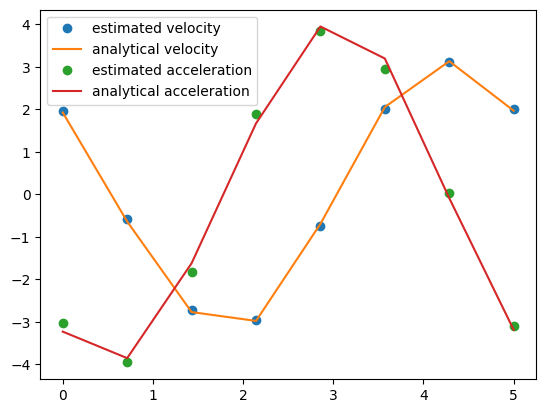

In [43]:
plt.plot(t, f[:,0],'o', label = "estimated velocity")
plt.plot(t, input_data[:,1], label = "analytical velocity")

plt.plot(t, f[:,1],'o', label = "estimated acceleration")
plt.plot(t, target_outputs[:,1], label = "analytical acceleration")

plt.legend()
plt.show()

### Solving the learned outputs to get learned trajectories 

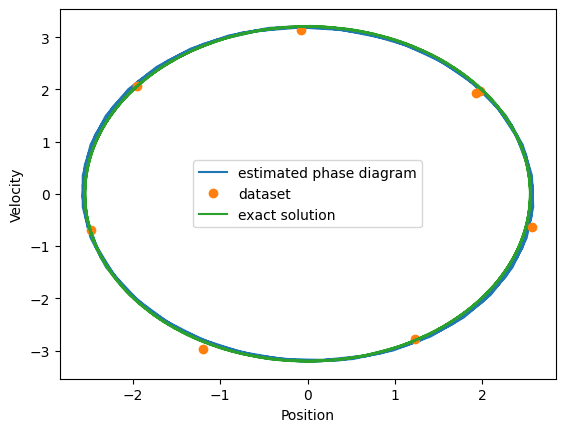

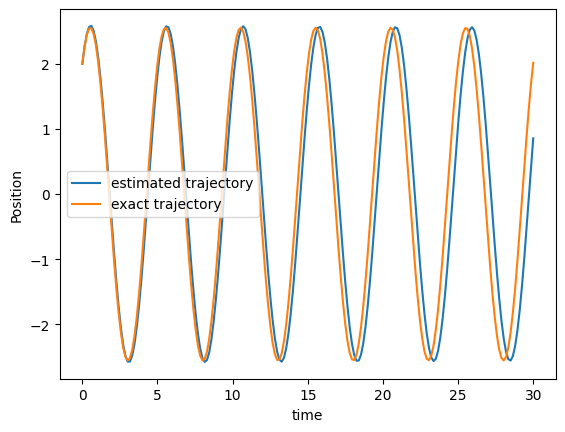

In [44]:
def ivp_learned_outputs(t, x):
    
    f = np.zeros_like(x)  # Output array for [velocity, acceleration]
    for j in range(num_datapoints):

        kernel_matrix = odd_symplectic_kernel(x, input_data[j], sigma)
        alpha_j = alpha[j * num_states:(j + 1) * num_states]  # Shape (num_states,)
        f += kernel_matrix @ alpha_j  # Matrix-vector multiplication
    return f
    
sol = solve_ivp(ivp_learned_outputs, [0, 30], init_values, t_eval=np.linspace(0, 30, 200)) 
sol_exact = solve_ivp(damped_oscillator, (0, 30), init_values, t_eval = np.linspace(0, 30, 200))

plt.plot(sol.y[0], sol.y[1], label = "estimated phase diagram")
plt.plot(input_data[:,0], input_data[:,1], 'o', label = "dataset")
plt.plot(sol_exact.y[0], sol_exact.y[1], label = "exact solution")
plt.xlabel("Position")
plt.ylabel("Velocity")
#plt.title("Estimated Phase plot with vector valued rbf")
plt.legend()
plt.savefig("Symplectic_kernel_phase.png")
plt.show()
plt.plot(np.linspace(0, 30, 200), sol.y[0], label="estimated trajectory")
plt.plot(np.linspace(0, 30, 200), sol_exact.y[0], label="exact trajectory")
plt.xlabel("time")
plt.ylabel("Position")
#plt.title("Estimated trajectory plot for vector valued rbf")
plt.legend()
plt.savefig("Symplectic_kernel_trajectory.png")
plt.show()

### Compute MSE over several iterations

In [46]:
def evaluate_mse(true_q, pred_q, true_qdot, pred_qdot, weight_q=0.5, weight_qdot=0.5):
    # Compute individual MSE
    mse_q = np.mean((true_q - pred_q)**2)
    mse_qdot = np.mean((true_qdot - pred_qdot)**2)
    # Combine with weights
    total_mse = weight_q * mse_q + weight_qdot * mse_qdot
    return mse_q, mse_qdot, total_mse

def average_mse(num_runs, p, v, a, noise_std, sigma, lam, damped_oscillator, init_values, t_eval):
    mse_q_list, mse_qdot_list, total_mse_list = [], [], []
    for _ in range(num_runs):
        # Generate noisy data
        input_data, target_outputs = generate_noisy_data(p, v, a, noise_std)
        
        # Compute Gram matrix and dual coefficients
        K = gram_matrix(input_data, sigma)
        alpha = dual_coeff(K, target_outputs.flatten(), lam)
        # Solve learned dynamics
        def ivp_learned_outputs(t, x):
            f = np.zeros_like(x)
            for j in range(input_data.shape[0]):
                kernel_matrix = odd_symplectic_kernel(x, input_data[j], sigma)
                alpha_j = alpha[j * len(x):(j + 1) * len(x)]  # Adjust for num_states
                f += kernel_matrix @ alpha_j
            return f
        
        sol = solve_ivp(ivp_learned_outputs, [0, 30], init_values, t_eval=t_eval)
        sol_exact = solve_ivp(damped_oscillator, [0, 30], init_values, t_eval=t_eval)
        
        # Compute MSE
        mse_q, mse_qdot, total_mse = evaluate_mse(
            sol_exact.y[0], sol.y[0],
            sol_exact.y[1], sol.y[1]
        )
        
        # Store results
        mse_q_list.append(mse_q)
        mse_qdot_list.append(mse_qdot)
        total_mse_list.append(total_mse)

    # Compute averages and standard deviations
    avg_mse_q = np.mean(mse_q_list)
    std_mse_q = np.std(mse_q_list)

    avg_mse_qdot = np.mean(mse_qdot_list)
    std_mse_qdot = np.std(mse_qdot_list)

    avg_total_mse = np.mean(total_mse_list)
    std_total_mse = np.std(total_mse_list)

    return avg_mse_q, std_mse_q, avg_mse_qdot, std_mse_qdot, avg_total_mse, std_total_mse

num_runs = 50
t_eval = np.linspace(0, 30, 200)
results = average_mse(
    num_runs=num_runs,
    p=p,
    v=v,
    a=a,
    noise_std=0.1,
    sigma=sigma,
    lam=lam,
    damped_oscillator=damped_oscillator,
    init_values=init_values,
    t_eval=t_eval
)


print(f"Average MSE (Position): {results[0]:.4f} ± {results[1]:.4f}")
print(f"Average MSE (Velocity): {results[2]:.4f} ± {results[3]:.4f}")
print(f"Average Total MSE: {results[4]:.4f} ± {results[5]:.4f}")


Average MSE (Position): 0.5255 ± 0.6385
Average MSE (Velocity): 0.7582 ± 0.9250
Average Total MSE: 0.6419 ± 0.7811
